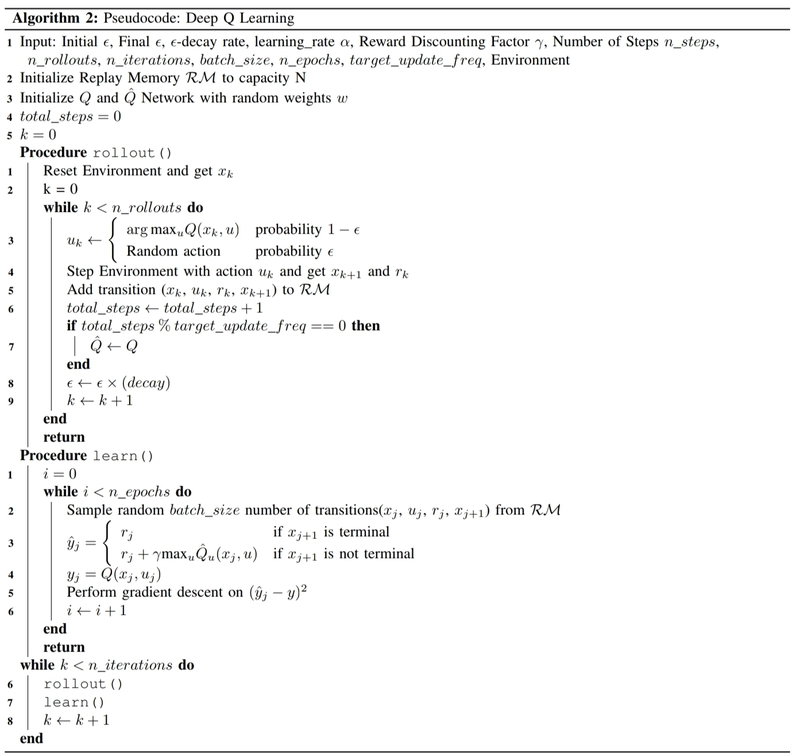

In [1]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from torch.optim import AdamW
from copy import deepcopy
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F




In [17]:
def gaussian(x, mu, sigma, max_amp):
    return max_amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

class PendulumDiscreteStateAction(gym.Wrapper):
    def __init__(self, env: gym.Env, nvec_u: int, sigma: float):
        super(PendulumDiscreteStateAction, self).__init__(env)

        self.env = env
        self.nvec_u = nvec_u

        self.action_space = gym.spaces.Discrete(nvec_u)

        kernel = gaussian(np.linspace(0, 1, nvec_u//2), 0, sigma, self.env.action_space.high[0])
        self.actions = (-kernel).tolist() + [0] + np.flip(kernel).tolist()

    def step(self, action: int) -> tuple[np.ndarray[float], float, bool, dict]:
        action = self.actions[action]
        obs, reward, terminated, truncated, info = self.env.step([action])
        reward = reward/16.2736044 # normalization (-1 and 1)
        obs: np.ndarray[float] = obs/self.env.observation_space.high # normalize observation (-1 and 0)
        return obs, reward, terminated, truncated, info
    
    def reset(self) -> tuple[np.ndarray[float], dict]:
        obs, info = self.env.reset()
        obs: np.ndarray[float] = obs/self.env.observation_space.high
        return obs, info
    
class QNetwork(nn.Module):
    def __init__(self, nvec_s, nvec_u):
        super(QNetwork, self).__init__()
        
        self.fc1 = nn.Linear(nvec_s, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, nvec_u)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class ReplayMemory:
    def __init__(self, capacity, env: gym.Env, device: torch.device):
        self.position = 0
        self.size = 0
        self.capacity = capacity
        self.device = device

        self.n_states = env.observation_space.shape
        self.n_actions = env.action_space.n

        self.states = np.zeros((capacity, *self.n_states))
        self.actions = np.zeros(capacity)
        self.rewards = np.zeros(capacity)
        self.next_states = np.zeros((capacity, *self.n_states))
        self.terminated = np.zeros(capacity)
        self.truncated = np.zeros(capacity)

    def push(self, state:np.ndarray, action:int, next_state:np.ndarray, reward:float, terminated: bool, truncated:bool):
        self.states[self.position] = state.flatten()
        self.actions[self.position] = action
        self.next_states[self.position] = next_state.flatten()
        self.rewards[self.position] = reward
        self.terminated[self.position] = terminated
        self.truncated[self.position] = truncated

        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        indices = np.random.choice(self.size, batch_size, replace=False)
        
        states = torch.tensor(self.states[indices], dtype=torch.float32, device=self.device)
        actions = torch.tensor(self.actions[indices], dtype = torch.int64, device=self.device)
        next_states = torch.tensor(self.next_states[indices], dtype = torch.float32, device=self.device)
        rewards = torch.tensor(self.rewards[indices], dtype=torch.float32, device=self.device)
        terminated = torch.tensor(self.terminated[indices], dtype=torch.float32, device=self.device)
        truncated = torch.tensor(self.terminated[indices], dtype=torch.float32, device=self.device)

        return states, actions, next_states, rewards, terminated, truncated
    
    def __len__(self):
        return len(self.size)
    

In [21]:

    
class Agent:
    def __init__(
            self,
            env: gym.Env,
            gamma=0.99,
            alpha=0.0003,
            initial_epsilon=1,
            min_epsilon=0.1,
            decay_rate=0.9999,
            batch_size=64,
            n_rollouts=2000,
            capacity=100000,
            device: torch.device = torch.device("cpu"),
    ):
        self.env = env
        self.device = device
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = initial_epsilon
        self.batch_size = batch_size
        self.n_rollouts = n_rollouts

        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate

        self.replay_memory = ReplayMemory(capacity, env, device)

        self.q_network = QNetwork(env.observation_space.shape[0], env.action_space.n).to(device)
        self.target_network = deepcopy(self.q_network)

        self.optimizer = AdamW(self.q_network.parameters(), lr=alpha)

        self.n_states = env.observation_space.shape[0]

        self.n_time_steps = 0
        self.episodes = 0
        self.n_updates = 0
        self.best_reward = -np.inf

    def get_action(self, obs, greedy=False):
        if not greedy and np.random.rand() < self.epsilon:
            return np.random.randint(self.env.action_space.n)
        obs = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        self.q_network.eval()
        with torch.no_grad():
            q_values: torch.Tensor = self.q_network(obs)
            return q_values.argmax().item()
        
    def sample_experience(self):
        return self.replay_memory.sample(self.batch_size)
    
    def update_target(self):
        self.target_network.load_state_dict(self.q_network.state_dict())


    def collect_rollouts(self):
        obs, info = self.env.reset()
        terminated = False
        truncated = False
        rewards = 0
        episodes = 0

        for _ in range(self.n_rollouts):
            action = self.get_action(obs, greedy=False)
            next_obs, reward, terminated, truncated, _ = self.env.step(action)
            self.replay_memory.push(
                obs, action, next_obs, reward, terminated, truncated
            )
            obs = next_obs
            rewards += reward
            self.n_time_steps += 1

            if terminated or truncated:
                episodes += 1
                obs, info = self.env.reset()

            self.epsilon = max(
                self.min_epsilon, self.decay_rate * self.epsilon
            )
        return rewards / episodes 

    def learn(self, epochs):
        self.q_network.train()

        average_loss = 0

        for i in range(epochs):
            obs, action, next_obs, reward, terminated, truncated = (self.sample_experience())
            q_values: torch.Tensor = self.q_network(obs)
            next_q_values = self.target_network(next_obs)

            q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
            next_q_value = next_q_values.max(1).values
            target = reward + self.gamma * next_q_value * (1 - terminated) * (1 - truncated)

            loss = F.smooth_l1_loss(q_value, target)

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 10)
            self.optimizer.step()

            average_loss += (loss.item() - average_loss) / (i + 1)
            self.n_updates += 1

            if self.n_updates % 1000 == 0:
                self.update_target()

        return average_loss

    def evaluate(self, n_steps):
        self.q_network.eval()
        rewards = 0
        episodes = 0

        with torch.no_grad():
            obs, info = self.env.reset()
            for _ in range(n_steps):
                action = self.get_action(obs, greedy=True)
                obs, reward, terminated, truncated, _ = self.env.step(action)
                rewards += reward

                if terminated or truncated:
                    episodes += 1
                    self.env.reset()

            
            rewards /= episodes
            if rewards > self.best_reward:
                self.best_reward = rewards
                torch.save(self.q_network.state_dict(), "dqn_best_model.pth")
                print("New best model saved.")
            return rewards
        
    def train(self, epochs):
        self.writer = SummaryWriter(log_dir="dqn_logs/DQN_2")

        pbar = tqdm(range(epochs))
        for i in pbar:
            rewards = self.collect_rollouts()
            loss = self.learn(int(self.n_rollouts/2))
            eval_reward = self.evaluate(1000)

            pbar.set_description(
                f"Iteration {i+1} || Reward: {rewards:.3f} || Eval Reward: {eval_reward :.3f} || Loss: {loss:.3f} || Epsilon: {self.epsilon:.2f} || Time steps: {self.n_time_steps} || N updates: {self.n_updates}"
            )  # Update progress bar
            self.writer.add_scalar("Training/Loss", loss, self.n_updates)  # Log training loss
            self.writer.add_scalar(
                "Training/Rollout: Mean Episode Reward", rewards, self.n_updates
            )  # Log mean episode reward during training
            self.writer.add_scalar(
                "Evaluation/Mean Episode Reward", eval_reward, self.n_updates
            )  # Log mean episode reward during evaluation


In [22]:


env = gym.make("Pendulum-v1")
env._max_episode_steps = 500
env = PendulumDiscreteStateAction(env, 11, 0.4)

agent = Agent(env)
agent.train(30)




Iteration 1 || Reward: -217.372 || Eval Reward: -200.109 || Loss: 0.004 || Epsilon: 0.82 || Time steps: 2000 || N updates: 1000:   3%|▎         | 1/30 [00:00<00:22,  1.28it/s]

New best model saved.


Iteration 5 || Reward: -230.920 || Eval Reward: -192.202 || Loss: 0.001 || Epsilon: 0.37 || Time steps: 10000 || N updates: 5000:  17%|█▋        | 5/30 [00:03<00:19,  1.30it/s]

New best model saved.


Iteration 6 || Reward: -199.069 || Eval Reward: -164.604 || Loss: 0.001 || Epsilon: 0.30 || Time steps: 12000 || N updates: 6000:  20%|██        | 6/30 [00:04<00:19,  1.24it/s]

New best model saved.


Iteration 7 || Reward: -177.772 || Eval Reward: -122.696 || Loss: 0.001 || Epsilon: 0.25 || Time steps: 14000 || N updates: 7000:  23%|██▎       | 7/30 [00:05<00:18,  1.23it/s]

New best model saved.


Iteration 10 || Reward: -91.240 || Eval Reward: -19.458 || Loss: 0.001 || Epsilon: 0.14 || Time steps: 20000 || N updates: 10000:  33%|███▎      | 10/30 [00:08<00:17,  1.17it/s]

New best model saved.


Iteration 11 || Reward: -30.852 || Eval Reward: -4.095 || Loss: 0.001 || Epsilon: 0.11 || Time steps: 22000 || N updates: 11000:  37%|███▋      | 11/30 [00:09<00:18,  1.05it/s] 

New best model saved.


Iteration 24 || Reward: -11.541 || Eval Reward: -3.864 || Loss: 0.006 || Epsilon: 0.10 || Time steps: 48000 || N updates: 24000:  80%|████████  | 24/30 [00:25<00:07,  1.30s/it] 

New best model saved.


Iteration 29 || Reward: -7.583 || Eval Reward: -3.802 || Loss: 0.007 || Epsilon: 0.10 || Time steps: 58000 || N updates: 29000:  97%|█████████▋| 29/30 [00:32<00:01,  1.50s/it]  

New best model saved.


Iteration 30 || Reward: -12.967 || Eval Reward: -7.740 || Loss: 0.007 || Epsilon: 0.10 || Time steps: 60000 || N updates: 30000: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


In [ ]:
import matplotlib.pyplot as plt

env = gym.make("Pendulum-v1",
            #    render_mode="human"
               )

env._max_episode_steps = 500
env = PendulumDiscreteStateAction(env, 11, 0.4)

agent = Agent(env)
agent.q_network.load_state_dict(torch.load("dqn_best_model.pth"))

rewards = []
thetas = []
tot_reward = 0
n_episodes = 100
n_steps = 0

for _ in range(n_episodes):
    obs, info = env.reset()
    terminated = False
    truncated = False

    while not terminated and not truncated:
        with torch.no_grad():
            action = agent.get_action(obs, greedy = True)

            obs, reward, terminated, truncated, info = env.step(action)
            x = obs[0] * env.observation_space.high[0]
            y = obs[1] * env.observation_space.high[1]
            theta = np.arctan2(y, x)
            thetas.append(theta)
            rewards.append(reward)
            tot_reward += reward
            n_steps += 1
            # env.render()

print("Total reward: ", tot_reward/n_episodes)

/Users/mistycloud/Projects/RL_Algorithms/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


KeyboardInterrupt: 

: 